# Imports

In [68]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge,Lasso
import numpy as np
import matplotlib.pyplot as plt

# DataSet

Loading

In [69]:
diabetes = datasets.load_diabetes()

Defining Features and Target

In [70]:
X = diabetes.data
y = diabetes.target

Data Splitting for Testing and Training

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=0)

# Ridge

Implmentation

In [75]:
class RidgeRegression:
    def __init__(self, regulizer=1.0):
        self.regulizer = regulizer  # Regularization strength
        self.coffs = None  # Model Weights
        self.b = None  # b term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        X_augmented = np.hstack([np.ones((n_samples, 1)), X])    # Augmentation (1's Column)

        I = np.eye(X_augmented.shape[1])
        I[0, 0] = 0  # for not regulizing b

        XtX = np.dot(X_augmented.T, X_augmented)  # XT * X
        XtY = np.dot(X_augmented.T, y)  # XT * y

        XtX_reg = XtX + self.regulizer * I      # XTX+λI

        XtX_reg_inv = np.linalg.inv(XtX_reg)    # (XTX+λI)^−1
        coffs = np.dot(XtX_reg_inv, XtY)        # W=(XTX+λI)^−1 XTy

        self.b = coffs[0]  # The first value is the b
        self.coffs = coffs[1:]  # The rest are the Weights


    def predict(self, X):
        #------np.dot(----------------Augmented X--------,-------b added to W in one vecto----)----
        return np.dot(np.hstack([np.ones((X.shape[0], 1)), X]), np.hstack([self.b, self.coffs]))   #y^=X⋅W




Performance

In [76]:
ridge_custom = RidgeRegression(regulizer=1.0)
ridge_custom.fit(X_train, y_train)

y_pred_custom = ridge_custom.predict(X_test)
mse_custom = mean_squared_error(y_test, y_pred_custom)
print("Custom Ridge Regression MSE:", mse_custom)

ridge_sklearn = Ridge(alpha=1.0)
ridge_sklearn.fit(X_train, y_train)
y_pred_sklearn = ridge_sklearn.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print("Scikit-learn Ridge Regression MSE:", mse_sklearn)

print("Custom Coefficients:", ridge_custom.coffs)
print("Scikit-learn Coefficients:", ridge_sklearn.coef_)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_custom_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_custom = RidgeRegression(regulizer=1.0)
    ridge_custom.fit(X_train, y_train)
    y_pred_custom = ridge_custom.predict(X_test)

    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_custom_scores.append(mse_custom)

mean_mse_custom = np.mean(mse_custom_scores)
print("Custom Ridge Regression Mean MSE with Cross-Validation:", mean_mse_custom)


Custom Ridge Regression MSE: 3379.4063076042657
Scikit-learn Ridge Regression MSE: 3379.4063076042657
Custom Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Scikit-learn Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Custom Ridge Regression Mean MSE with Cross-Validation: 3433.171835094969


Visualize

Performance for sklearn Model

In [77]:
mse_sklearn_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_sklearn = Ridge(alpha=1.0)
    ridge_sklearn.fit(X_train, y_train)
    y_pred_sklearn = ridge_sklearn.predict(X_test)

    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_sklearn_scores.append(mse_sklearn)

mean_mse_sklearn = np.mean(mse_sklearn_scores)
print("Scikit-learn Ridge Regression Mean MSE with Cross-Validation:", mean_mse_sklearn)

Scikit-learn Ridge Regression Mean MSE with Cross-Validation: 3433.1718350949695


Visualize

# Lasso

In [81]:
class Regression:
    def __init__(self, lr, itr, regularization):
        """
        learning_rate: A small value needed for gradient decent, default value id 0.1
        iteration: Number of training iteration, default value is 10,000
        """
        self.m = None # number of training samples
        self.n = None # number of features
        self.w = None # weights
        self.b = None # bias
        # will be the l1/l2 regularization class according to the regression model Lasso or ridge
        self.regularization = regularization
        self.lr = lr
        self.itr = itr

    def cost_function(self, y, y_pred):
        """
        y: Original target value
        y_pred: predicted target value
        """
        return (1 / (2*self.m)) * np.sum(np.square(y_pred - y)) + self.regularization(self.w)

    def hypothesis(self, w, b, X):
        """
        weights: parameter value weight
        X: Training samples
        b: bias
        """
        return np.dot(X, w)

    def train(self, X, y):
        """
        X: training data feature values ---> N Dimentional vector
        y: training data target value -----> 1 Dimentional array
        """
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)

        # Target value should be in the shape of (n, 1)
        # So, this will check that and change the shape to (n, 1), if not
        try:
            y.shape[1]
        except IndexError as e:
            # we need to change it to the 1 D array, not a list
            print("ERROR: Target array should be a one dimentional array not a list"
                  "----> here the target value not in the shape of (n,1). \nShape ({shape_y_0},1) and {shape_y} not match"
                  .format(shape_y_0=y.shape[0], shape_y=y.shape))
            return

        self.m = X.shape[0]

        self.n = X.shape[1]

        # initial weight
        self.w = np.zeros((self.n, 1))

        # bias
        self.b = 0

        for it in range(1, self.itr+1):
            '''
            # 1. Find the predicted value through the hypothesis
            # 2. Find the Cost function value
            # 3. Find the derivation of weights
            # 4. Apply Gradient Decent
            '''
            y_pred = self.hypothesis(self.w, self.b, X)
            # print("iteration",it) # debugging
            # print("y predict value", y_pred)  # debugging
            cost = self.cost_function(y, y_pred)
            # print("Cost function", cost)  # debugging
            # find the derivative
            dw = (1/self.m) * np.dot(X.T, (y_pred - y)) + \
                self.regularization.derivation(self.w)
            # print("weights derivation", dw)  # debugging
            # db = -(2 / self.m) * np.sum((y_pred - y)) # bias derivation

            # change the weight parameter.
            self.w = self.w - self.lr * dw
            # print("updated weights",self.w) # debugging
            # self.b = self.b - self.lr * db # change the bias parameter

            # if it % 10 == 0: # print cost value every 10 iteration
            #     print(
            #         "The Cost function for the iteration {}----->{} :)".format(it, cost))

    def predict(self, test_X):
        """
        :param test_X: feature values to predict
        """
        # Insert constant ones for bias weights
        test_X = np.insert(test_X, 0, 1, axis=1)

        y_pred = self.hypothesis(self.w, self.b, test_X)
        return y_pred

In [82]:
# Create the regularization class we want.
class l1_regularization:
    """Regularization used for Lasson Regression"""
    def __init__(self, lamda):
        self.lamda = lamda

    def __call__(self, w):
        return self.lamda * np.sum(np.abs(w))

    def derivation(self, w):
        "Derivation of the regularization function"
        return self.lamda * np.sign(w)  # the sign function returns (-1 if x < 0, 0 if x==0, 1 if x > 0) taken from numpy documentation

In [83]:
class LassoRegression(Regression):
    """
    Lasso Regression is one of the variance of the Linear Regression. This model doing the parameter learning
    and regularization at the same time. This model uses the l1-regularization.
    * Regularization will be one of the soluions to the Overfitting.
    * Overfitting happens when the model has "High Variance and low bias". So, regularization adds a little bias to the model.
    * This model will try to keep the balance between learning the parameters and the complexity of the model( tries to keep the parameter having small value and small degree of polynomial).
    * The Regularization parameter(lamda) controls how severe  the regularization is.
    * large lamda adds more bias , hence the Variance will go very small --> this may cause underfitting(Low bias and High Varinace).
    * Lamda can be found by trial and error methos.
    """

    def __init__(self, lamda, lr, itr):
        """
        lamda: Regularization factor.
        learning_rate: A samll value needed for gradient decent, default value id 0.1
        iteration: Number of training iteration, default value is 10,000
        """
        self.regularization = l1_regularization(lamda)
        super(LassoRegression, self).__init__(
            lr, itr, self.regularization)

    def train(self, X, y):
        """
        X: training data feature values ---> N Dimentional vector
        y: training data target value -----> 1 Dimentional array
        """
        return super(LassoRegression, self).train(X, y)

    def predict(self, test_X):
        """
        test_X: Value need to be predicted
        """
        return super(LassoRegression, self).predict(test_X)

In [84]:
Y = y[:, np.newaxis]
print("="*100)
print("Number of training data samples-----> {}".format(X.shape[0]))
print("Number of training features --------> {}".format(X.shape[1]))
print("Shape of the target value ----------> {}".format(y.shape))

Number of training data samples-----> 442
Number of training features --------> 10
Shape of the target value ----------> (442,)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.20, random_state=0)
model = LassoRegression(lamda=0.01, lr=0.01, itr=100)


# Train
model.train(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(y_pred.flatten())

[96.54759886 96.60577036 96.22677372 95.84129028 96.01802976 96.49930232
 95.75014957 96.45030624 95.78229679 96.26246582 95.90720935 96.50569889
 95.77785295 95.51589309 96.88866965 95.68956571 95.8848689  95.44796308
 95.42544641 96.63139975 96.08741137 95.89888061 96.22265127 95.76159846
 96.47076039 96.20455601 95.79253921 95.57841632 96.13499265 96.3240355
 96.39998551 95.56699138 95.76838344 96.04199004 96.33381486 96.26482123
 96.20047519 96.42884506 95.96005155 96.39603622 95.686996   96.38102298
 96.16287934 96.10852691 96.47639776 95.58242397 95.92587005 95.91556379
 96.18117017 96.55271878 96.10172825 95.6509326  96.0217601  96.31266973
 96.42339558 96.55001905 96.46731949 95.50336695 96.30147255 96.39365025
 96.18836243 95.95344883 96.21671775 96.12114681 96.53087246 95.92977021
 95.58506841 96.80026886 96.52690918 95.49093443 95.53964067 96.26402222
 95.9079127  95.85925614 95.90502081 96.46167371 96.17979527 96.63672113
 96.79234697 96.38702041 96.16258582 96.56705577 95.

In [86]:
model = Lasso(alpha=0.01, max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[236.8713307  248.60597737 163.73055705 120.85744682 184.83272252
 258.85935182 113.48666276 188.14554987 153.72917516 233.94642695
 169.48479309 177.32211958 110.07911816  93.88994618 240.6723391
  90.61897384 152.65632701  68.63310699 101.93015532 215.40221977
 196.07580588 159.29083134 160.5647282  159.34438292 197.35819476
 166.96919224 116.57496432  85.59341242 187.78029376 159.28332815
 173.17001049  86.56114131 145.16411011 143.57491635 141.37207059
 194.25536213 163.86916221 186.2044823  130.23473033 204.55484629
  84.80163388 161.95636275 144.36620545 183.0170948  176.0066054
  76.52841545 140.01033942 139.58791279 119.94481184 232.0245689
 160.67289376  77.88439732 156.3225029  155.11300192 235.61532866
 170.1315249  188.23622332 119.44438714 132.28441985 169.54645218
 212.29691463 169.95706503 159.12213019 109.93832636 263.46045496
 151.22476714  83.94503073 226.55462948 199.49074494  43.52810923
  81.91371617 129.6190777  103.72746244 144.64410867 133.15268163
 185.4993336 

In [87]:
# --- Custom Cross-validation Code for Custom Lasso Regression ---
lambdas = [0.001, 0.01, 0.1, 1, 10]
k_folds = 5  # Number of folds for cross-validation
lambda_mse_scores = {}

for lamda in lambdas:
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = LassoRegression(lamda=lamda, lr=0.01, itr=100)
        model.train(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        mse = np.mean((y_val_pred - y_val_fold) ** 2)
        mse_scores.append(mse)

    lambda_mse_scores[lamda] = np.mean(mse_scores)

best_lambda = min(lambda_mse_scores, key=lambda x: lambda_mse_scores[x])
print(f"Best Lambda from Cross-Validation: {best_lambda}")

Best Lambda from Cross-Validation: 0.001


In [88]:
# Train the final custom Lasso model with the best lambda
final_custom_model = LassoRegression(lamda=best_lambda, lr=0.01, itr=100)
final_custom_model.train(X_train, y_train)
final_custom_y_pred = final_custom_model.predict(X_test)

# --- Scikit-learn Lasso Model with Cross-Validation ---
param_grid = {'alpha': lambdas}
grid_search = GridSearchCV(
    Lasso(max_iter=1000), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha from Scikit-learn GridSearchCV: {best_alpha}")

final_sklearn_model = Lasso(alpha=best_alpha, max_iter=1000)
final_sklearn_model.fit(X_train, y_train)
final_sklearn_y_pred = final_sklearn_model.predict(X_test)

Best Alpha from Scikit-learn GridSearchCV: 0.01


In [89]:
# --- Calculate Mean Squared Errors ---
mse_custom = np.mean((final_custom_y_pred - y_test) ** 2)
mse_sklearn = np.mean((final_sklearn_y_pred - y_test) ** 2)
mse_cross_val_best = lambda_mse_scores[best_lambda]

print(f"MSE (Custom Lasso): {mse_custom}")
print(f"MSE (Scikit-learn Lasso): {mse_sklearn}")
print(f"MSE (Cross-Validated Best Lambda): {mse_cross_val_best}")

MSE (Custom Lasso): 8474.298964957155
MSE (Scikit-learn Lasso): 7570.53914525395
MSE (Cross-Validated Best Lambda): 9212.841237725403


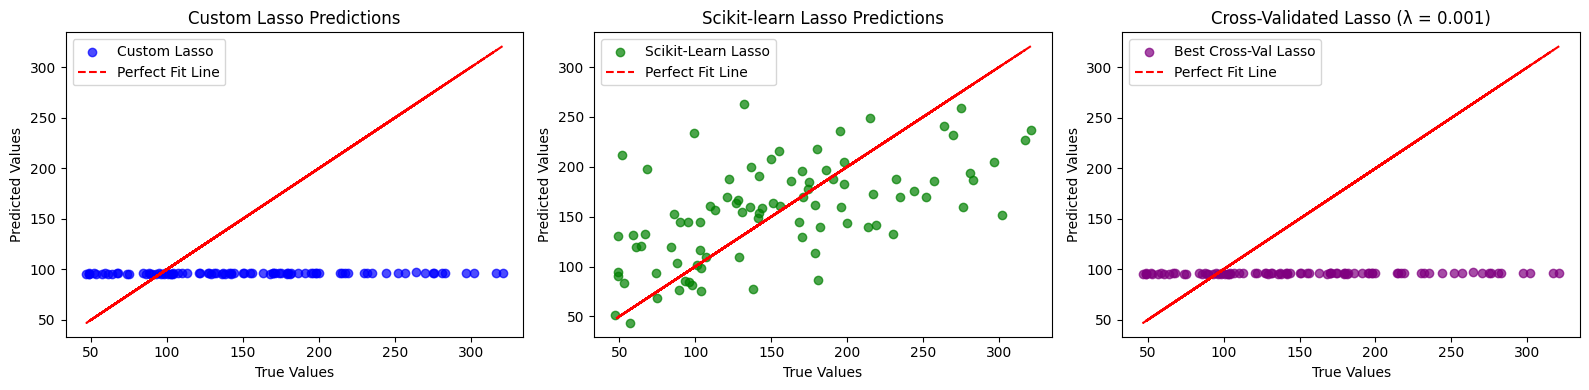

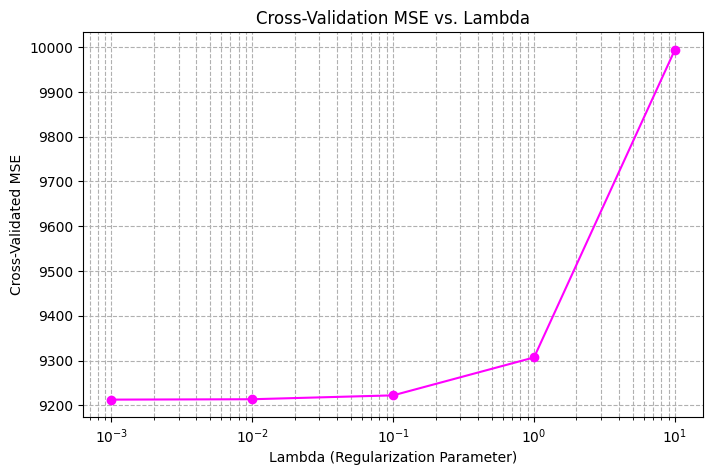

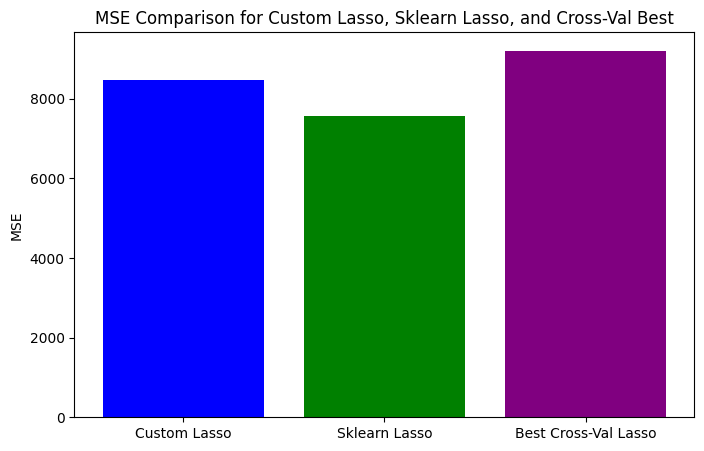

In [90]:
# --- Plot 1: Predictions vs. True Values ---
plt.figure(figsize=(16, 4))

# Custom Lasso Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_test, final_custom_y_pred, color='blue',
            label='Custom Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Custom Lasso Predictions')
plt.legend()

# Scikit-learn Lasso Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, final_sklearn_y_pred, color='green',
            label='Scikit-Learn Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scikit-learn Lasso Predictions')
plt.legend()

# Final Cross-Validated Lasso Predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test, final_custom_y_pred, color='purple',
            label='Best Cross-Val Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Cross-Validated Lasso (λ = {best_lambda})')
plt.legend()

plt.tight_layout()
plt.show()

# --- Plot 2: MSE vs. Lambda ---
plt.figure(figsize=(8, 5))
plt.plot(list(lambda_mse_scores.keys()), list(
    lambda_mse_scores.values()), marker='o', color='magenta')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation MSE vs. Lambda')
plt.xscale('log')
plt.grid(True, linestyle='--', which='both')
plt.show()

# --- Plot 3: MSE Comparison (Custom vs. Sklearn vs. Cross-Val) ---
mse_values = [mse_custom, mse_sklearn, mse_cross_val_best]
mse_labels = ['Custom Lasso', 'Sklearn Lasso', 'Best Cross-Val Lasso']

plt.figure(figsize=(8, 5))
plt.bar(mse_labels, mse_values, color=['blue', 'green', 'purple'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom Lasso, Sklearn Lasso, and Cross-Val Best')
plt.show()

# ElasticNet

Implmentation

In [91]:
class elasticNet:
  def __init__(self, Lambda, Alpha,no_of_iterations,lr): # lambda is l1_penalty ,alpha is l2 penalty 
    self.Lambda = Lambda
    self.Alpha = Alpha
    self.no_of_iterations = no_of_iterations
    self.lr = lr
    self.shapeX = X_train.shape[0]
    self.shapeY = X_train.shape[1]

    self.w = np.zeros(self.shapeY)

    self.b = 0
    

  def weightUpdate(self):
    y_pred = self.predict(self.X_train)
    dW = np.zeros(self.shapeY) #initialized with zeros then will be updated based on no_of_iterations parameter
    for i in range(self.shapeY):
      if self.w[i]>0:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) ) + self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX 
      else:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) )- self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX 
      db = -2 * np.sum(self.Y_train - y_pred)/self.shapeX
      self.w = self.w - self.lr * dW
      self.b = self.b - self.lr * db

      return self
  def fit(self,X_train,Y_train):
    self.X_train = X_train

    self.Y_train = Y_train

    for i in range(self.no_of_iterations):
      self.weightUpdate()

    return self

  def predict(self,X_test):
    return X_test.dot(self.w) + self.b




Performance

In [92]:
elastic = elasticNet(0.1,0.3, 500,0.1)
elastic.fit(X_train,y_train)
y_predict = elastic.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
print(acc)

ValueError: setting an array element with a sequence.

Visualize

Performance for sklearn Model

In [ ]:
elasticSklearn = ElasticNet(alpha=0.3,l1_ratio=0.1,max_iter=500)
elasticSklearn.fit(X_train,y_train)
y_predict = elasticSklearn.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
print(acc)

5704.680682647094


Visualize